# Phase Contrast WFS simulation

Zernike polynomials can be used to describe the aberrations in optical wavefront traveling through a circular aperture.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio

We will start by creating a 2D co-ordinate array and then apply a circular mask to act as the pupil for our system. The pupil will initally have an electric field of uniform amplitude passing through it.

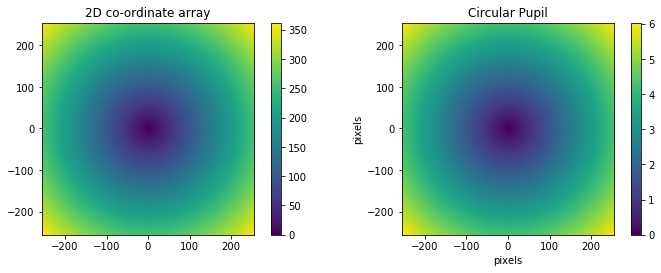

In [10]:
numPixels = 512        #size of arrays
wavelength = 0.68

x = np.arange( -numPixels / 2, numPixels / 2)
y = x

pupilRadius = 60

#meshgrid function used to create a co-ordinate
#array that vectorises x and y
X, Y = np.meshgrid(x, y)

theta = np.arctan2(Y,X)

#R is now an array with values equal to the distance
# from the center of the N x N array:
R = np.sqrt((X)**2 + (Y)**2)

#create a cirular pupil mask filling the array, in the form of booleans
R_norm = R/pupilRadius

fig = plt.figure(figsize=(10, 7))

plt.subplot(221)
plt.imshow(R, extent=(x.min(), x.max(), x.min(), x.max()))
plt.title('2D co-ordinate array')
plt.colorbar()

plt.subplot(222)
plt.imshow(R_norm, extent=(x.min(), x.max(), x.min(), x.max()))
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.colorbar()
plt.title('Circular Pupil')

plt.tight_layout()
plt.show()

#adjust co-ordinates so that the pupil is between 0 and 1

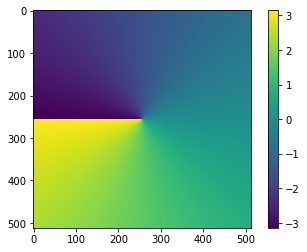

3.14159265359


In [11]:
fig = plt.figure()
plt.imshow(theta)
plt.colorbar()
plt.show()

print(np.max(theta))

Now that we have generated our input pupil for the incoming wavefront, we can find the point spread function of the system by taking a Fourier transform of the circular pupil.

In [12]:
#define a function that can calculate all the variables we need, psf, phase and angle

def PSF(array):
    
    global fft, psf, phase
    
    #fourier transform of curcular pupil
    #fftshift function moves zero frequency function to the centre of the array
    fft = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(array)))
    
    #change the fft into an intensity distribution
    psf = np.abs(fft)**2
    #normalise the psf
    psf = psf/np.max((psf))
    
    #extract angle information from the pupil
    phase = np.angle(fft)
    
    return {'fft':fft ,'psf':psf, 'phase':phase}


def Interference(array):
    
    global ifft, I, Iphase
    
    ifft = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(array)))
    
    I = np.abs(ifft)**2
    #I = I/np.max((I))
    
    Iphase = np.angle((ifft))
    
    return {'ifft':ifft, 'I':I, 'Iphase':Iphase }

0.0430641174316


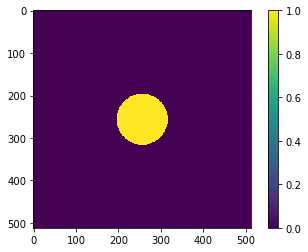

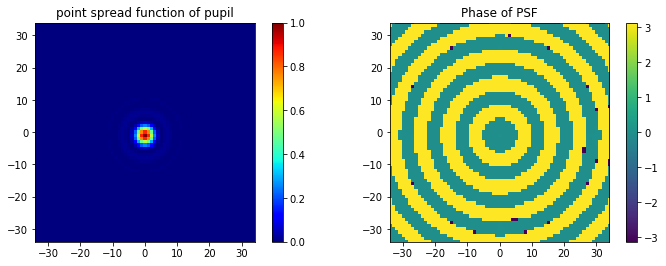

In [13]:
pupilMask = np.ones((numPixels, numPixels))
pupilMask[R_norm>1]=0

PSF(pupilMask)
plt.imshow(pupilMask)
plt.colorbar()

fig = plt.figure(figsize=(10,7))
plt.clf()
plt.subplot(221)
plt.imshow((psf), extent=(x.min(), x.max(), x.min(), x.max()), Cmap='jet')
plt.gca().set_xlim((-34, 34))
plt.gca().set_ylim((-34, 34))
plt.title('point spread function of pupil')
plt.colorbar()

plt.subplot(222)
plt.imshow((phase), extent=(x.min(), x.max(), x.min(), x.max()))
plt.gca().set_xlim((-34, 34))
plt.gca().set_ylim((-34, 34))
plt.title('Phase of PSF')
plt.colorbar()

print(np.mean(pupilMask))
plt.tight_layout()
plt.show()


We have now generated our point spread function in the form of an intensity and phase distribution.

## Wavefront Aberrations

So far we have created a basic optical system with no wavefront aberrations. We can model wavefront aberrations by multiplying the pupil array of the aperture by a zernike polynomial.

In [14]:
#Zernike polynomials
#-------------------------------------------------------------------------------------------------

Z_0 = 1*pupilMask
Z_1 = 2*R_norm*np.sin(theta)                                     #Y-Tilt
Z_2 = 2*R_norm*np.cos(theta)                                     #X-Tilt
Z_3 = np.sqrt(6)*(R_norm**2)*np.sin(2*theta)                     #Oblique astigmatism
Z_4 = np.sqrt(3)*(2*(R_norm**2)-1)                               #Defocus
Z_5 = np.sqrt(6)*(R_norm**2)*np.cos(2*theta)                     #Vertical astigmatism
Z_6 = np.sqrt(8)*(R_norm**3)*np.sin(3*theta)                     #Vertical Trefoil
Z_7 = np.sqrt(8)*(3*(R_norm**3)-2*R_norm)*np.sin(theta)          #Vertical Coma
Z_8 = np.sqrt(8)*(3*(R_norm**3)-2*R_norm)*np.cos(theta)          #Horizontal Coma
Z_9 = np.sqrt(8)*(R_norm**3)*np.sin(3*theta)                     #Oblique trefoil
Z_10 = np.sqrt(10)*(R_norm**4)*np.sin(4*theta)                   #Oblique quadrafoil
Z_11 = np.sqrt(10)*(4*(R_norm**4)-3*(R_norm**2))*np.sin(2*theta) #Oblique seconday astigmatism
Z_12 = np.sqrt(5)*((6*(R_norm**4)-6*(R_norm**2))+1)                #primary spherical
Z_13 = np.sqrt(10)*(4*(R_norm**4)-3*(R_norm**2))*np.cos(2*theta) #Vertical secondary astigmatism  
Z_14 = np.sqrt(10)*(R_norm**4)*np.cos(4*theta)                   #Vertical quadrafoil

#-------------------------------------------------------------------------------------------------

Zernike_polynomials = np.array([Z_0, Z_1, Z_2, Z_3, Z_4, Z_5, Z_6, Z_7, Z_8, Z_9, Z_10, Z_11, Z_12, Z_13, Z_14])

#map Zernike polynomials to pupil in order to model aberrated wavefronts
for i in range(len(Zernike_polynomials)):
    Zernike_polynomials[i][R_norm>1]=0


titles = ['pupil','Y-Tilt', 'X-Tilt','Oblique_astigmatism', 'Defocus', 'Vertical_astigmatism', 'Vertical_Trefoil', 
          'Vertical_Coma', 'Horizontal_Coma', 'Oblique_trefoil', 'Oblique_quadrafoil', 'Oblique_seconday_astigmatism',
          'primary_spherical', 'Vertical_secondary_astigmatism', 'Vertical_quadrafoil']

#check the RMS values of the aberrated wavefronts
RMS = []

for i in range(len(Zernike_polynomials)):
    
    root_mean_square = np.sqrt(np.sum(Zernike_polynomials[i]**2))
    #Zernike_polynomials[i]=Zernike_polynomials[i]/root_mean_square
    RMS.append(np.sqrt(np.sum(Zernike_polynomials[i]**2)))
    
print(RMS)

[106.24970588194586, 106.15263643556962, 106.15263643556963, 106.26217957207261, 106.05769467605828, 105.84948350964807, 105.95990288668878, 105.96440544943896, 105.96440544943897, 105.95990288668878, 106.22636382132973, 106.20709246943032, 105.8757651912922, 105.53750564378886, 105.50090856910005]


Can specify the amount of wavefront aberration by dividing the amount of aberration we want by the wavelength
and multiplying it by the delta value
delta = aberrated_wavefronts/wavelength

In [15]:
wavelength = 0.68 #microns
rms = 0.1
delta = Zernike_polynomials/wavelength

#Convert to phase
pupil = np.exp((rms*delta)*2*np.pi*1j)

#map pupil functions to aperture radius
for i in range(len(pupil)):
    pupil[i][R_norm>1]=0


We can check if our simulation is working correctly by plotting the amplitude of the pupil is equal to 1 accross the pupil mask

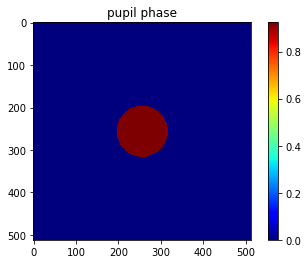

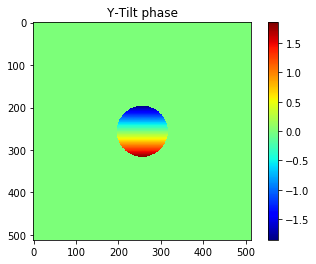

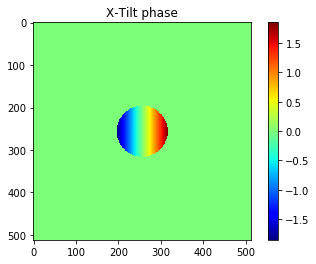

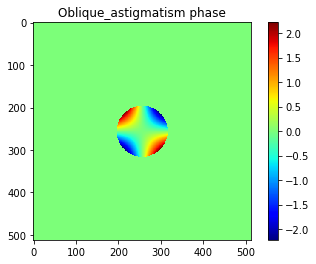

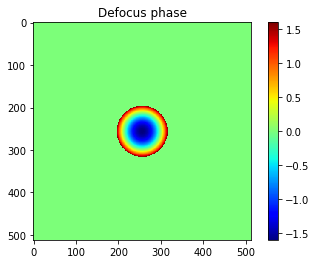

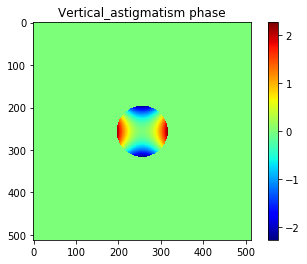

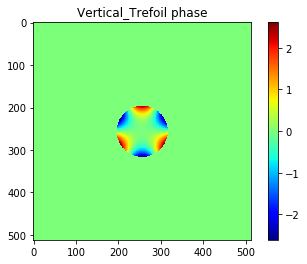

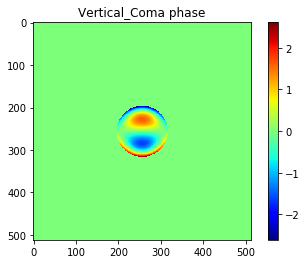

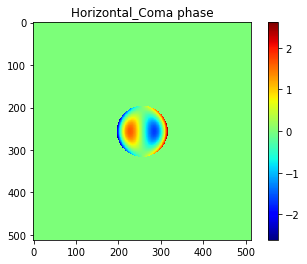

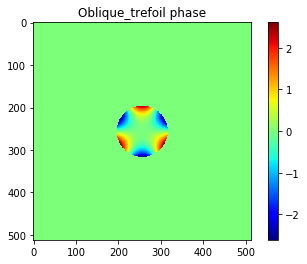

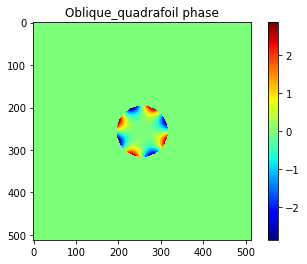

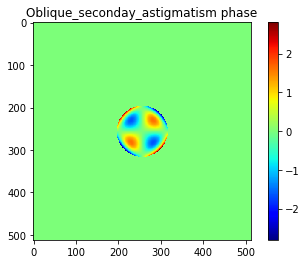

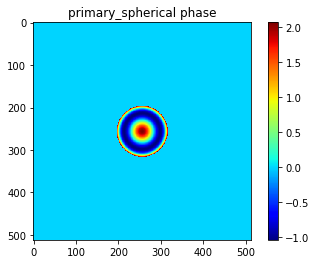

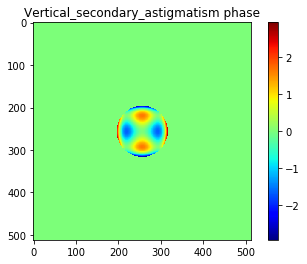

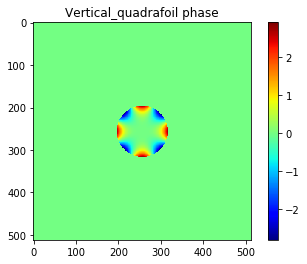

In [16]:
t = 0
for i in range(len(pupil)):
    
    fig = plt.figure()
    
    plt.imshow(np.angle(pupil[i]), Cmap='jet')
    
    plt.title(titles[t]+' phase')
    #plt.gca().set_xlim((-34, 34))
    #plt.gca().set_ylim((-34, 34))
    plt.colorbar()
    #fig.savefig(titles[t] + "Input_01rms" + ".pdf")
    t+=1
plt.show()

We now want to see how these Zernike polynomials effect to PSF, which can be dont by taking their fourier transform.

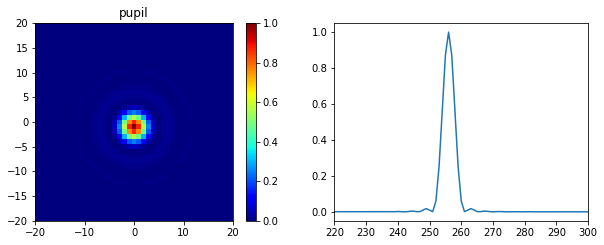

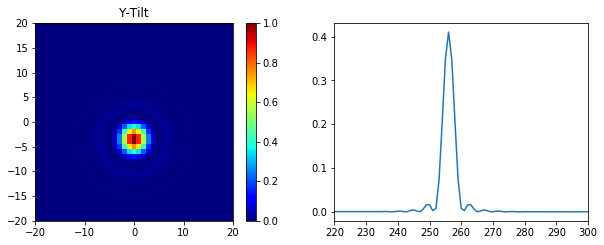

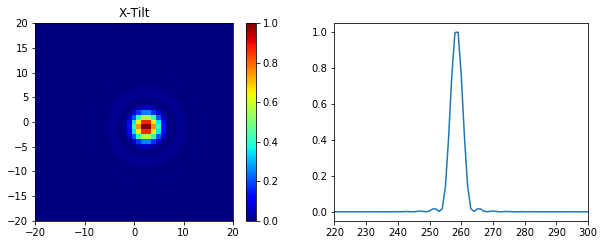

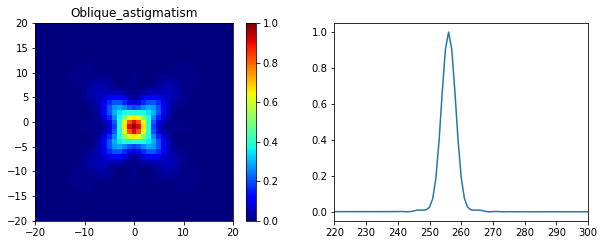

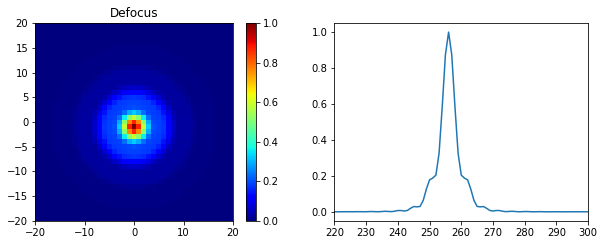

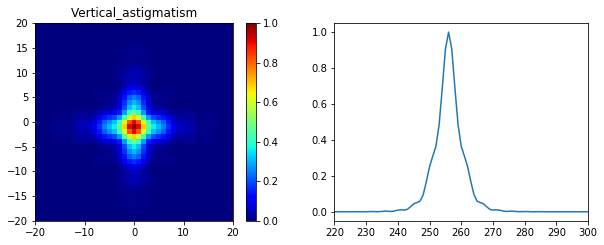

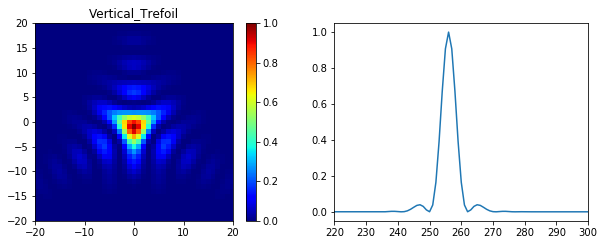

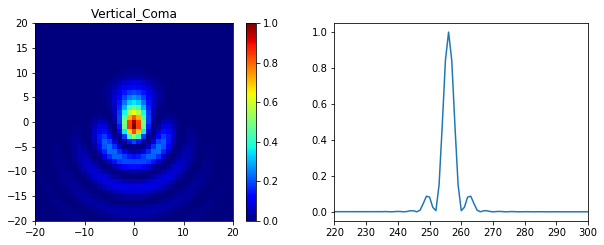

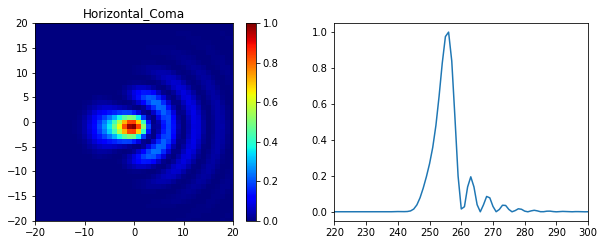

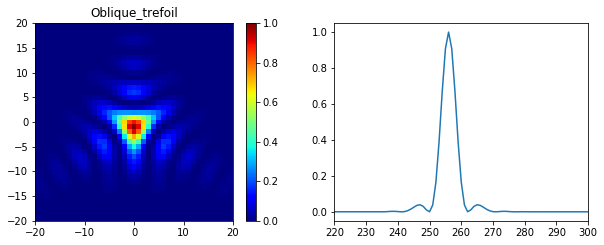

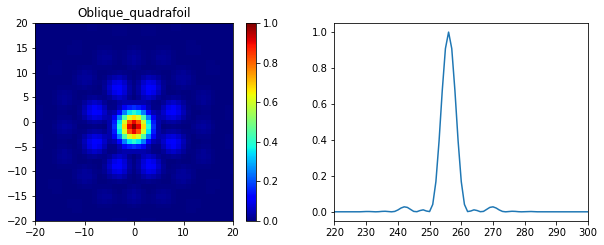

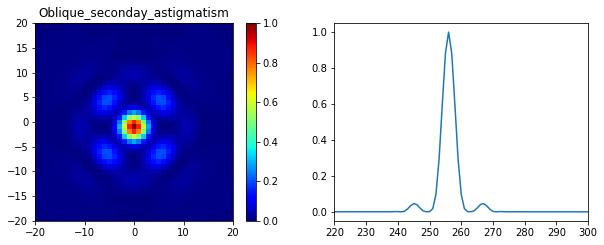

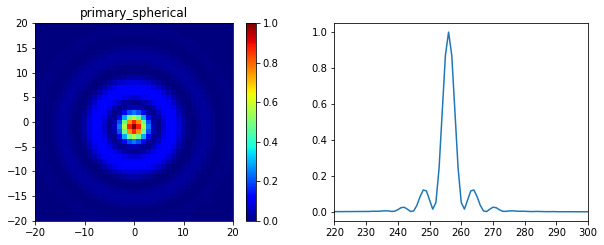

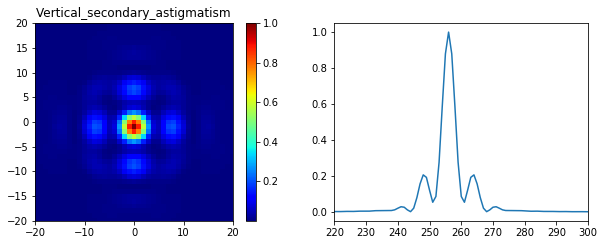

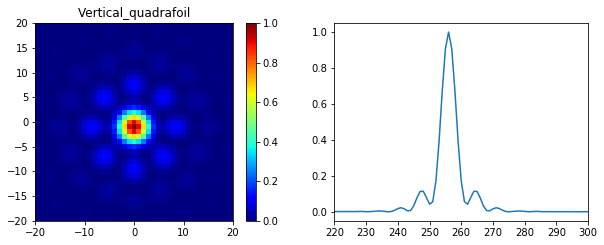

In [17]:
fourier_plane = []
t=0
for i in range(len(pupil)):
    
    fourier_plane.append(PSF(pupil[i]))
    
    fig = plt.figure(figsize=(10,8))
    plt.subplot(221)
    plt.imshow((fourier_plane[i]['psf']), extent=(x.min(), x.max(), x.min(), x.max()), Cmap='jet')
    plt.gca().set_xlim((-20, 20))
    plt.gca().set_ylim((-20, 20))
    plt.title(titles[t])
    plt.colorbar()

    plt.subplot(222)
    plt.plot((fourier_plane[i]['psf'][256,:]))
    plt.gca().set_xlim((220,300))
    #fig.savefig(titles[t] + "_intensity_0.1rms" + ".pdf")
    t+=1
    
plt.show() 

#  Phase Shift filter

We can simulate the efeect of a phase contrast filter by intriducing a phase shift to the system.
This can be acheved by creating another electric field with a phase shift of pi/2 and multiplying it by our object in the Fourier plane.
The phase shift will create another pertubrbed sythetic reference wavefefront that has the ability to interfere with the original wavefront. The interference will give rise to an intensity distribution that allows us to examine the phase aberration of the system.

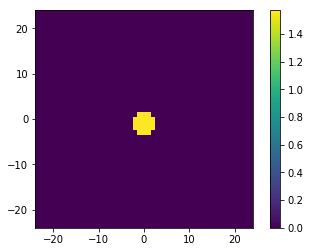

In [20]:
#PCF need to be a size comparable to that of the airy disk
#could calculate the size of the airy disk through autocorrelation
PCF_radius = 2.5
R_norm2 = R/PCF_radius
mask2 = np.ones((numPixels, numPixels))


#introduce multiple phase shifts
PCF_1 = mask2 * np.exp(-1j*(np.pi/2))
PCF_1[R_norm2>1]=1

PCF_2 = mask2 *np.exp(1j*0)
PCF_2[R_norm2>1]=1

PCF_3 = mask2 * np.exp(1j*np.pi/2)
PCF_3[R_norm2>1]=1

PCF_4 = mask2 * np.exp(1j*np.pi)
PCF_4[R_norm2>1]=1


#Intensity of filter is 1 throughout
#phase shift is applied only to area of PCF

fig = plt.figure()
plt.imshow(np.angle(PCF_3), extent = (x.min(), x.max(), y.min(), y.max()))
plt.gca().set_xlim((-24,24))
plt.gca().set_ylim((-24,24))
plt.colorbar()
plt.show()

#np.savetxt('PCF', np.abs(PCF))


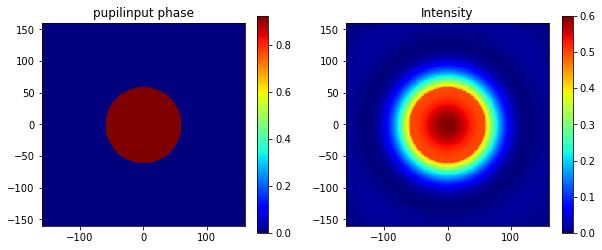

0
input max: 0.923997839291
output max: 0.600338095653
ratio:  1.53912911072


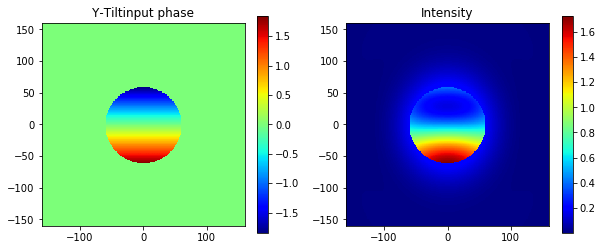

1
input max: 1.84799567858
output max: 1.72787611708
ratio:  1.06951861902


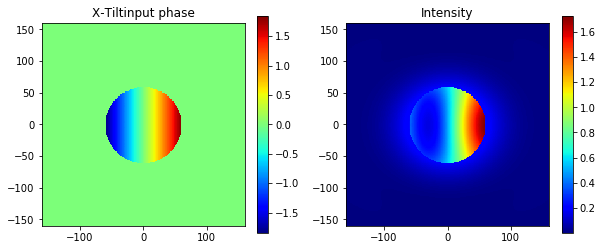

2
input max: 1.84799567858
output max: 1.72787611708
ratio:  1.06951861902


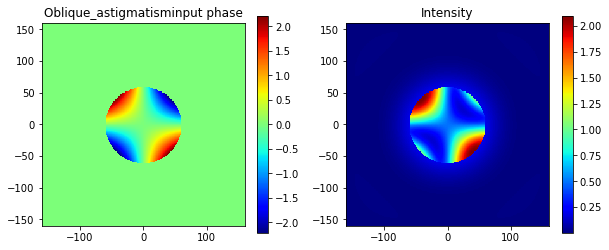

3
input max: 2.2180567651
output max: 2.0989781321
ratio:  1.05673171682


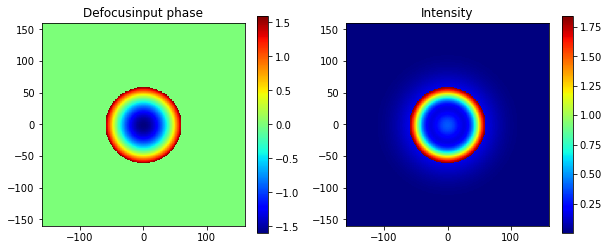

4
input max: 1.60041120374
output max: 1.84421025008
ratio:  0.867803008724


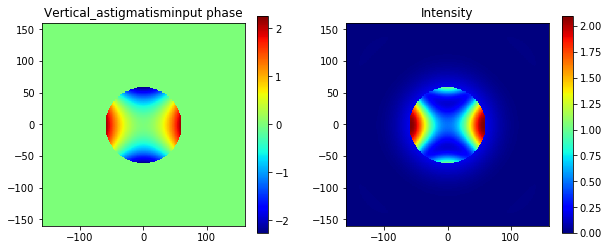

5
input max: 2.2633232297
output max: 2.10211641862
ratio:  1.07668786069


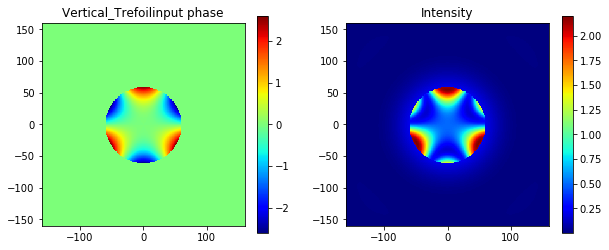

6
input max: 2.61346055186
output max: 2.20120860201
ratio:  1.18728436254


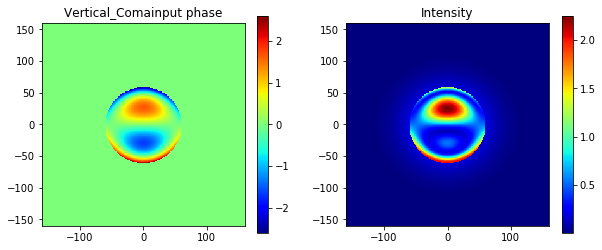

7
input max: 2.61346055186
output max: 2.252780739
ratio:  1.16010426874


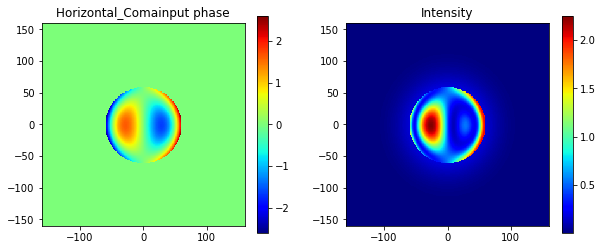

8
input max: 2.61346055186
output max: 2.252780739
ratio:  1.16010426874


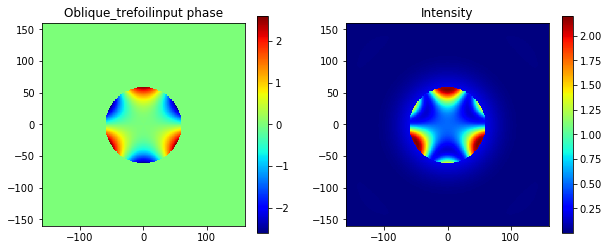

9
input max: 2.61346055186
output max: 2.20120860201
ratio:  1.18728436254


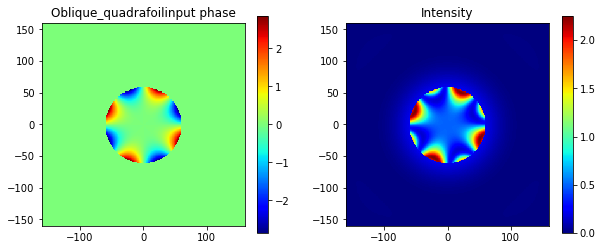

10
input max: 2.85819619486
output max: 2.25357348694
ratio:  1.26829509285


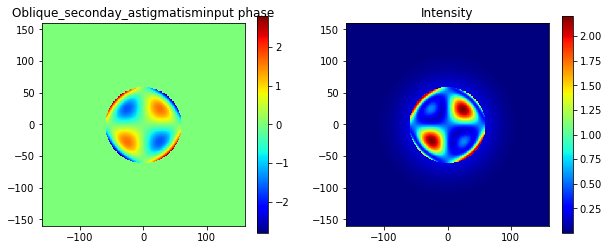

11
input max: 2.80506021622
output max: 2.20726835576
ratio:  1.27082880924


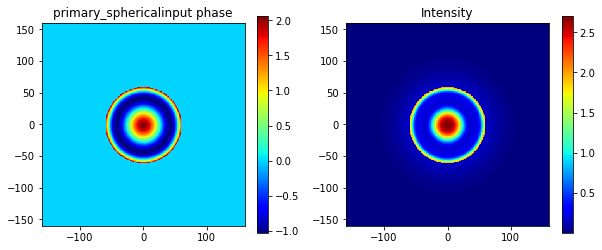

12
input max: 2.06612197972
output max: 2.70693061433
ratio:  0.763271126633


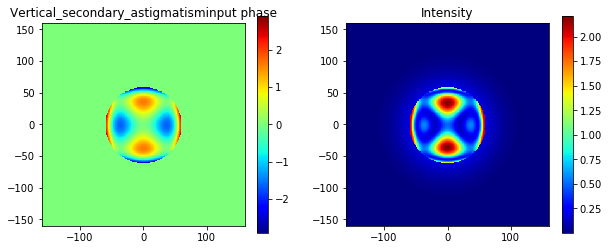

13
input max: 2.92193772523
output max: 2.21275862289
ratio:  1.32049546436


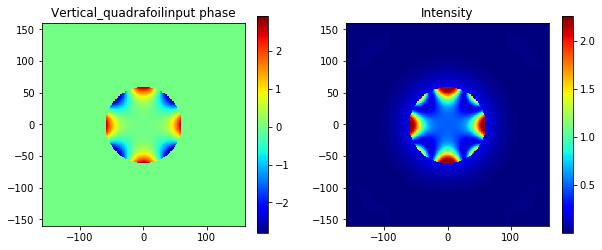

14
input max: 2.92193772523
output max: 2.25842850158
ratio:  1.2937924416


In [21]:
t=0
reconstructed_phase=[]
E1 = []
E2 = []
E3 = []
E4 = []
for i in range(len(pupil)):
    
    #synthetic reference wavefront
    SRW1 = fourier_plane[i]['fft'] * PCF_1
    SRW2 = fourier_plane[i]['fft'] * PCF_2
    SRW3 = fourier_plane[i]['fft'] * PCF_3
    SRW4 = fourier_plane[i]['fft'] * PCF_4
    
    E1.append(Interference(SRW1))
    E2.append(Interference(SRW2))
    E3.append(Interference(SRW3))
    E4.append(Interference(SRW4))
    
    #I0 = (E1[i]['I']+E2[i]['I']+E3[i]['I']+E4[i]['I'])/4
    reconstructed_phase.append((E3[i]['I'] - E1[i]['I'])/4)
    
    fig = plt.figure(figsize=(10,4))
    plt.clf()
    plt.subplot(1,2,1)
    plt.imshow(np.angle(pupil[i]), extent=(x.min(), x.max(), x.min(), x.max()), Cmap='jet')
    plt.gca().set_xlim((-160, 160))
    plt.gca().set_ylim((-160, 160))
    plt.colorbar()
    plt.title(titles[t] + 'input phase')
    
    plt.subplot(1,2, 2)
    plt.imshow(E3[i]['I'],  extent=(x.min(), x.max(), x.min(), x.max()), Cmap='jet')
    plt.gca().set_xlim((-160, 160))
    plt.gca().set_ylim((-160, 160))
    plt.title('Intensity')
    plt.colorbar()
    
    plt.show()
    print(t)
    m = np.max(np.angle(pupil[i]))
    n = np.max(E3[i]['I'])
    print('input max:', m)
    print('output max:', n)
    print('ratio: ', m/n)
    t+=1

    


Find the range of the system by comparing changes in the rms aberration values

Compare the output intensity for different sized of PCF




